In [1]:
import os
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import torch.optim as optimizer
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
from tqdm.auto import tqdm

In [2]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3090'

In [3]:
path = './BRATS-2/Image_Data/HG/0003/'
p = os.listdir(path)
p.sort(key=str.lower)
arr = []
for i in range(len(p)):
    if(i != 4):
        p1 = os.listdir(path+'/'+p[i])
        p1.sort()
        img = sitk.ReadImage(path+'/'+p[i]+'/'+p1[-1])
        arr.append(sitk.GetArrayFromImage(img))
    else:
        p1 = os.listdir(path+'/'+p[i])
        img = sitk.ReadImage(path+'/'+p[i]+'/'+p1[0])
        Y_labels = sitk.GetArrayFromImage(img) 
        print(Y_labels.shape)
data = np.zeros((Y_labels.shape[1],Y_labels.shape[0],Y_labels.shape[2],4))
for i in range(Y_labels.shape[1]):
    data[i,:,:,0] = arr[0][:,i,:]
    data[i,:,:,1] = arr[1][:,i,:]
    data[i,:,:,2] = arr[2][:,i,:]
    data[i,:,:,3] = arr[3][:,i,:]

(176, 216, 176)


In [4]:
Y_labels.shape

(176, 216, 176)

In [5]:
data.shape

(216, 176, 176, 4)

Populating the interactive namespace from numpy and matplotlib
(176, 176)


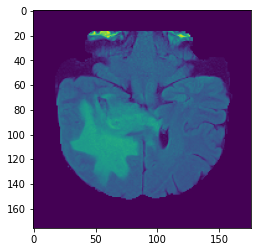

In [6]:
%pylab inline
img = data[126,:,:,0]
print(img.shape)
imgplot = plt.imshow(img)
plt.show()
plt.imsave('slice_126_4.png',img,cmap='gray')

Populating the interactive namespace from numpy and matplotlib
(176, 176)


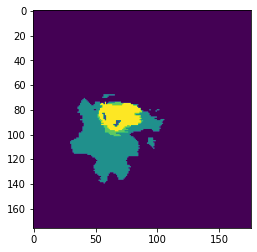

In [7]:
%pylab inline
img = Y_labels[:,126,:]
print(img.shape)
imgplot = plt.imshow(img)
plt.show()
#plt.imsave('slice_126_GT',img,cmap='gray')

In [8]:
def model_gen1(input_dim,x,y,slice_no):
    X1 = []
    X2 = []
    Y = []
  
    for i in range(int((input_dim)/2),y.shape[0]-int((input_dim)/2)):
        for j in range(int((input_dim)/2),y.shape[2]-int((input_dim)/2)):
        #Filtering all 0 patches
            if(x[i-16:i+17,j-16:j+17,:].any != 0):
                X2.append(x[i-16:i+17,j-16:j+17,:])
                X1.append(x[i-int((input_dim)/2):i+int((input_dim)/2)+1,j-int((input_dim)/2):j+int((input_dim)/2)+1,:])
                Y.append(y[i,slice_no,j])
      
      
    X1 = np.asarray(X1)
    X2 = np.asarray(X2)
    Y = np.asarray(Y)
    d = [X1,X2,Y]
    return d

In [9]:
def model_gen2(input_dim,x,y,slice_no):
    X1 = []
    X2 = []
    Y = []
  
    for i in range(int((input_dim)/2),y.shape[0]-int((input_dim)/2)):
        for j in range(int((input_dim)/2),y.shape[2]-int((input_dim)/2)):
          #Filtering all 0 patches
          if(x[i-16:i+17,j-16:j+17,:].any != 0):
            X2.append(x[i-16:i+17,j-16:j+17,:])
            X1.append(x[i-int((input_dim)/2):i+int((input_dim)/2),j-int((input_dim)/2):j+int((input_dim)/2),:])
            Y.append(y[i,slice_no,j])
      
      
    X1 = np.asarray(X1)
    X2 = np.asarray(X2)
    Y = np.asarray(Y)
    d = [X1,X2,Y]
    return d

In [10]:
def data_gen(data,y,slice_no,model_no):
    d = []
    x = data[slice_no]
    #filtering all 0 slices and non-tumor slices
    if(x.any() != 0 and y.any() != 0):
        if(model_no == 0):
            X1 = []
            for i in range(16,159):
                for j in range(16,199):
                    if(x[i-16:i+17,j-16:j+17,:].all != 0):
                        X1.append(x[i-16:i+17,j-16:j+17,:])
            Y1 = []
            for i in range(16,159):
                for j in range(16,199):
                    if(x[i-16:i+17,j-16:j+17,:].all != 0):
                        Y1.append(y[i,slice_no,j]) 
            X1 = np.asarray(X1)
            Y1 = np.asarray(Y1)
            d = [X1,Y1]
    elif(model_no == 1):
        d = model_gen1(65,x,y,slice_no)
    elif(model_no == 2):
        d = model_gen2(56,x,y,slice_no)
    elif(model_no == 3):
        d = model_gen1(53,x,y,slice_no)  
    return d   

In [11]:
class CustomImageDataset(Dataset):
    def __init__(self, x_b, x_s, y):
        self.img_labels = torch.argmax(torch.tensor(y).type(torch.torch.LongTensor), dim=1)
        self.img_b = torch.tensor(x_b).type(torch.torch.FloatTensor).permute(0, 3, 1, 2)
        self.img_s = torch.tensor(x_s).type(torch.torch.FloatTensor).permute(0, 3, 1, 2)
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        label = self.img_labels[idx]
        image_b = self.img_b[idx]
        image_s = self.img_s[idx]
        return image_b, image_s, label

# 모델 구현 23쪽 참고

In [12]:
class two_path(nn.Module):
    def __init__(self, input_size = 4):
        super(two_path,self).__init__()
        # input_channel = 4x65x65    4 is type of data ex) t1,t2, tc, f
        # first line
        self.conv7_7_1 = nn.Sequential(nn.Conv2d(input_size,64,kernel_size=(7,7), stride=(1,1),padding =0),
                             nn.BatchNorm2d(64))
        
        self.conv7_7_2 = nn.Sequential(nn.Conv2d(input_size,64,kernel_size=(7,7),stride=(1,1),padding =0),
                             nn.BatchNorm2d(64))
        
        self.conv3_3_1 = nn.Sequential(nn.Conv2d(64, 64,kernel_size=(3,3), stride=(1,1), padding =0),
                            nn.BatchNorm2d(64))
        
        self.conv3_3_2 = nn.Sequential(nn.Conv2d(64, 64,kernel_size=(3,3), stride=(1,1), padding =0),
                            nn.BatchNorm2d(64))
        self.maxpool_4 = torch.nn.MaxPool2d(4, stride=1, padding=0)
        self.maxpool_2 = torch.nn.MaxPool2d(2, stride=1, padding=0)
        
        # second line
        self.conv13_13_1 = nn.Sequential(nn.Conv2d(input_size,160,kernel_size=(13,13), stride=(1,1), padding =0),
                            nn.BatchNorm2d(160))
        
        self.conv13_13_2 = nn.Sequential(nn.Conv2d(input_size,160,kernel_size=(13,13), stride=(1,1), padding =0),
                            nn.BatchNorm2d(160))
    def max_out(self,x,y):
        return torch.max(x,y)

        
    def forward(self, input_x):
        #local_path 1 
        x1_11 = self.conv7_7_1(input_x)
        x1_12 = self.conv7_7_2(input_x)
        x1_1  = self.max_out(x1_11, x1_12)
        x1_1  = self.maxpool_4(x1_1)
        x1_21 = self.conv3_3_1(x1_1)
        x1_22 = self.conv3_3_2(x1_1)
        x1_2  = self.max_out(x1_21, x1_22)
        x1    = self.maxpool_2(x1_2)
        
        #local_path 2 
        x21  = self.conv13_13_1(input_x)
        x22  = self.conv13_13_1(input_x)
        x2   = self.max_out(x21, x22)
        
        # concat        
        x = torch.cat((x1, x2),dim=1) # 0: batch_size, 1: channel, 2,3 : img.shape
        return x

## (a)

In [13]:
class input_cascade(nn.Module):
    def __init__(self):
        super(input_cascade, self).__init__()
        self.two_path1 = two_path(4) # input_channel : 4
        self.two_path2 = two_path(9) # input_channel: 9 
        self.conv1 = nn.Conv2d(224,5,kernel_size=(21,21),stride=(1,1),padding =0)#two_path input size: 224 
        self.conv2 = nn.Conv2d(224,5,kernel_size=(21,21),stride=(1,1),padding =0)
        

    def forward(self,x1, x2):          #x1: 4x65x65 , x2 = 4x33x33
        # local path 1
        x1 = self.two_path1(x1)
        x1 = self.conv1(x1)
        x1 = F.softmax(x1, dim=1)             
        
        # local path 2        
        x  = torch.cat((x1,x2), dim=1) # 0: batch_size, 1: channel_input, 2,3 : img.shape
        x  = self.two_path2(x)
        x  = self.conv2(x)
        x = x.squeeze()
        x = F.softmax(x, dim=1)
        return x
    
model_input_cascade = input_cascade()
model_input_cascade = model_input_cascade.to('cuda')

## (b)

In [14]:
class two_pathcnn(nn.Module):
    def __init__(self):
        super(two_pathcnn, self).__init__()
        self.two_path1 = two_path(4) # input_channel : 4
        
        self.conv7_7_1 = nn.Sequential(nn.Conv2d(4,64,kernel_size=(7,7), stride=(1,1),padding =0),
                             nn.BatchNorm2d(64))
        
        self.conv7_7_2 = nn.Sequential(nn.Conv2d(4,64,kernel_size=(7,7),stride=(1,1),padding =0),
                             nn.BatchNorm2d(64))
        
        self.conv3_3_1 = nn.Sequential(nn.Conv2d(69, 64,kernel_size=(3,3), stride=(1,1), padding =0),
                            nn.BatchNorm2d(64))
        
        self.conv3_3_2 = nn.Sequential(nn.Conv2d(69, 64,kernel_size=(3,3), stride=(1,1), padding =0),
                            nn.BatchNorm2d(64))
        self.maxpool_4 = torch.nn.MaxPool2d(4, stride=1, padding=0)
        self.maxpool_2 = torch.nn.MaxPool2d(2, stride=1, padding=0)
        
        # second line
        self.conv13_13_1 = nn.Sequential(nn.Conv2d(4,160,kernel_size=(13,13), stride=(1,1), padding =0),
                            nn.BatchNorm2d(160))
        
        self.conv13_13_2 = nn.Sequential(nn.Conv2d(4,160,kernel_size=(13,13), stride=(1,1), padding =0),
                            nn.BatchNorm2d(160))
        
        self.conv1 = nn.Conv2d(224,5,kernel_size=(21,21),stride=(1,1),padding =0)#two_path input size: 224 
        self.conv2 = nn.Conv2d(224,5,kernel_size=(21,21),stride=(1,1),padding =0)
        
    def max_out(self,x,y):
        return torch.max(x,y)
    
        
    def forward(self, x1, x2):         #x1: 4x56x56 , x2 = 4x33x33
        # local path 1
        x1 = self.two_path1(x1)
        x1 = self.conv1(x1)
        x1 = F.softmax(x1, dim=1)
        
        # local path 2-1
        
        x2_2_11 = self.conv7_7_1(x2)
        x2_2_12 = self.conv7_7_2(x2)
        x2_2_1  = self.max_out(x2_2_11, x2_2_12)
        x2_2_1  = self.maxpool_4(x2_2_1)
        x2_2_1 = torch.cat((x1, x2_2_1), dim=1)  # 0: batch_size, 1: channel_input, 2,3 : img.shape
        x2_2_21 = self.conv3_3_1(x2_2_1)
        x2_2_22 = self.conv3_3_2(x2_2_1)
        x2_2_22  = self.max_out(x2_2_21, x2_2_22)
        x2_2_1    = self.maxpool_2(x2_2_22)
        
        # local path 2-2
        x2_2_211 = self.conv13_13_1(x2)
        x2_2_212 = self.conv13_13_1(x2)
        x2_2_2  = self.max_out(x2_2_211, x2_2_212)
        
        x = torch.cat((x2_2_1, x2_2_2),dim=1) # 0: batch_size, 1: channel, 2,3 : img.shape
        x = self.conv2(x)
        x = x.squeeze()
        x = F.softmax(x, dim=1)
        
        return x
        
model_cnn = two_pathcnn()
model_cnn = model_cnn.to('cuda')

## (c)

In [15]:
class MFCcascade(nn.Module):
    def __init__(self):
        super(MFCcascade, self).__init__()
        self.two_path1 = two_path(4) # input_channel : 4
        self.two_path2 = two_path(4) # input_channel: 4 
        self.conv1 = nn.Conv2d(224,5,kernel_size=(21,21),stride=(1,1),padding =0)#two_path input size: 224 
        self.conv2 = nn.Conv2d(229,5,kernel_size=(21,21),stride=(1,1),padding =0)
        
    def forward(self,x1, x2):         #x1: 4x53x53 , x2 = 4x33x33
        # local path 1
        x1 = self.two_path1(x1)
        
        x1 = self.conv1(x1)
        x1 = F.softmax(x1, dim=1)              # 5x21x21 
        
        # local path 2        
        x2 = self.two_path2(x2)
        x = torch.cat((x1,x2), dim=1) # 0: batch_size, 1: channel_input, 2,3 : img.shape
        x  = self.conv2(x)
        x = x.squeeze()
        x = F.softmax(x, dim=1)
        
        return x
    
model_MFC = MFCcascade()
model_MFC = model_MFC.to('cuda')

In [16]:
def train(n_epochs, train_loader, model, optimizer, scheduler, criterion, use_cuda, save_path):

    n_epoch = n_epochs

    train_losses = []
    valid_losses = []

    valid_loss_min = np.Inf 


    for epoch in range(1, n_epoch+1):

        train_loss = 0.0
        valid_loss = 0.0
    
        ###################
        # train the model #
        ###################

        model.train()

        for x_65, x_33, target in tqdm(train_loader):

            if use_cuda:
                x_65, x_33, target = x_65.cuda(), x_33.cuda(), target.cuda()
            optimizer.zero_grad()
          
            output = model(x_65, x_33)
            loss = criterion(output, target)

            loss.backward()
            
            optimizer.step()
          
            train_loss += loss.item()*x_65.size(0)
       
          ######################    
#         # validate the model #
#         ######################

#         model.eval()

#         for data, target in valid_loader:

#             if use_cuda:
#                 data, target = data.cuda(), target.cuda()

#             output = model(data)

#             loss = criterion(output, target)

#             valid_loss += loss.item()*data.size(0)
    
#         scheduler.step()

        
        train_loss = train_loss/len(train_loader.sampler)
#        valid_loss = valid_loss/len(valid_loader.sampler)
        
        train_losses.append(train_loss)
#        valid_losses.append(valid_loss)

        print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

        # if valid_loss <= valid_loss_min:
        #     print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
        #     torch.save(model.state_dict(), save_path)
        #     valid_loss_min = valid_loss
            
#     if(epoch>10 and epoch % 3 == 0):
#         bre = input(" break? 0 :")
#         if(bre == 0):
#             return model, train_losses, valid_losses
     
    return model, train_losses#, valid_losses


In [17]:
def test(batch_size, model, test_dataloader, train_on_gpu, criterion, classes):
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    model.eval()

    for data, target in tqdm(test_dataloader):

        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        output = model(data)
        
        loss = criterion(output, target)
        
        test_loss += loss.item()*data.size(0)
        
        _, pred = torch.max(output, 1)    
        
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        
        for i in range(batch_size):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # average test loss
    test_loss = test_loss/len(test_dataloader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    for i in range(len(classes)):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                classes[i], 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))

In [19]:
n_epochs = 1
model = model_MFC
opt = optimizer.Adam(model.parameters(), lr=1e-1)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer=opt ,step_size=15, gamma=0.1)
use_cuda = torch.cuda.is_available()
save_path = '.temp'

In [20]:
fold = os.listdir('./BRATS-2/Image_Data/HG/')
fold.sort(key=str.lower) 

for path in tqdm(fold):
    print(path)
    path = './BRATS-2/Image_Data/HG/'+path
    p = os.listdir(path)
    p.sort(key=str.lower)
    arr = []
    
    # Reading from 4 images and creating 4 channel slice-wise 
    for i in range(len(p)):
        if(i != 4):
            p1 = os.listdir(path+'/'+p[i])
            p1.sort()
            img = sitk.ReadImage(path+'/'+p[i]+'/'+p1[-1])
            arr.append(sitk.GetArrayFromImage(img))
        else:
            p1 = os.listdir(path+'/'+p[i])
            img = sitk.ReadImage(path+'/'+p[i]+'/'+p1[0])
            Y_labels = sitk.GetArrayFromImage(img)
    data = np.zeros((Y_labels.shape[1],Y_labels.shape[0],Y_labels.shape[2],4))
    for i in range(Y_labels.shape[1]):
        data[i,:,:,0] = arr[0][:,i,:]
        data[i,:,:,1] = arr[1][:,i,:]
        data[i,:,:,2] = arr[2][:,i,:]
        data[i,:,:,3] = arr[3][:,i,:]
    info = []
    
    # Creating patches for each slice and training(slice-wise)
    for i in range(data.shape[0]):
        d = data_gen(data,Y_labels,i,3)
        if(len(d) != 0):
            y = np.zeros((d[2].shape[0],5))
            for j in range(y.shape[0]):
                y[j,d[2][j]] = 1
            X1 = d[0]
            X2 = d[1]
            train_dataset = CustomImageDataset(X1, X2, y)
            train_dataLoader = DataLoader(train_dataset, batch_size=128, shuffle=True)
            
            model, train_loss_result = train(n_epochs, train_dataLoader, model_MFC, opt, scheduler, criterion, use_cuda, save_path)

                



  0%|          | 0/20 [00:00<?, ?it/s]

0001


  0%|          | 0/105 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [294]:
def predict():
    

IndentationError: expected an indented block (Temp/ipykernel_25644/1027369206.py, line 2)

In [22]:
path = './BRATS-2/Image_Data/HG/0027'
p = os.listdir(path)
p.sort(key=str.lower)
arr = []
for i in range(len(p)):
    if(i != 4):
        p1 = os.listdir(path+'/'+p[i])
        p1.sort()
        img = sitk.ReadImage(path+'/'+p[i]+'/'+p1[-1])
        arr.append(sitk.GetArrayFromImage(img))
    else:
        p1 = os.listdir(path+'/'+p[i])
        img = sitk.ReadImage(path+'/'+p[i]+'/'+p1[0])
        Y_labels = sitk.GetArrayFromImage(img)    
data = np.zeros((Y_labels.shape[1],Y_labels.shape[0],Y_labels.shape[2],4))
for i in range(Y_labels.shape[1]):
    data[i,:,:,0] = arr[0][:,i,:]
    data[i,:,:,1] = arr[1][:,i,:]
    data[i,:,:,2] = arr[2][:,i,:]
    data[i,:,:,3] = arr[3][:,i,:]
info = []
 
    
d = data_gen(data,Y_labels,113,3)
if(len(d) != 0):
    y = np.zeros((d[2].shape[0],1,1,5))
    for j in range(y.shape[0]):
        y[j,:,:,d[2][j]] = 1
    X1 = d[0]
    X2 = d[1]
    pred = model1.predict([X1,X2],batch_size = 256) 
    pred = np.around(pred)
    #print(pred.shape)
    pred1 = np.argmax(pred.reshape(y.shape[0],5)[:,1:4],axis = 1)
    y2 = np.argmax(y.reshape(y.shape[0],5)[:,1:4],axis = 1)
    f1 = metrics.f1_score(y2,pred1,average='micro')
    print(f1)